# Setting up our environment

In [1]:
# Clone repository untuk mendapatkan library yang akan digunakan untuk object detection
! git clone https://github.com/roboflow-ai/Monk_Object_Detection.git

Cloning into 'Monk_Object_Detection'...
remote: Enumerating objects: 3794, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 3794 (delta 28), reused 28 (delta 18), pack-reused 3747 (from 1)
Receiving objects: 100% (3794/3794), 132.21 MiB | 14.19 MiB/s, done.
Resolving deltas: 100% (828/828), done.
Updating files: 100% (4032/4032), done.


In [2]:
# Install library yang digunakan
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install

xargs: warning: options --max-args and -L are mutually exclusive, ignoring previous --max-args value
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 MB 2.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 3.7 MB/s eta 0:00:00
  Cloning https://github.com/abhi-kumar/cocoapi.git to /tmp/pip-install-ayvf3ten/pycocotools_e08f34e4822547fe9452440453845f1d
  Running command git clone --filter=blob:none --quiet https://github.com/abhi-kumar/cocoapi.git /tmp/pip-install-ayvf3ten/pycocotools_e08f34e4822547fe9452440453845f1d
  Resolved https://github.com/abhi-kumar/cocoapi.git to commit 1d6d019f8938f47a9b5af28685011898b25ff93a
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=376002 sha256=dc267899df4115594d32b2e55525d87

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Install library tqdm
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
# Install library
!pip install efficientnet_pytorch
!pip install tensorboardX

  ERROR: HTTP error 404 while getting https://github.com/chengs/tqdm/archive/colab.zip
ERROR: Could not install requirement https://github.com/chengs/tqdm/archive/colab.zip because of HTTP error 404 Client Error: Not Found for url: https://github.com/chengs/tqdm/archive/colab.zip for URL https://github.com/chengs/tqdm/archive/colab.zip
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8eab5ba79e876d0894cad7d07cbe017a2c03771c658d20c1eacd473903d83a76
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.6 MB/s eta 0:00:00


In [5]:
# Kalau mau run evaluation dan inference tanpa harus training, cukup run setting up our env, dataset preparation, dan evaluation, skip training dan save model
import os
import sys
import json
import torch
import numpy as np
import cv2
from pycocotools.coco import COCO
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
## Kalau pakai monk object detection di uncomment
# from infer_detector import Infer
# gtf = Infer();
# #our trained model weights are in here in onxx format
# gtf.Model(model_dir="trained/")

In [6]:
sys.path.append("Monk_Object_Detection/4_efficientdet/lib/");

In [7]:
system_dict = {};
system_dict["verbose"] = 1;
system_dict["local"] = {};
system_dict["local"]["common_size"] = 512;
system_dict["local"]["mean"] = np.array([[[0.485, 0.456, 0.406]]])
system_dict["local"]["std"] = np.array([[[0.229, 0.224, 0.225]]])
## Jalankan ini jika pakai cpu
#system_dict["local"]["model"] = torch.load("/content/drive/MyDrive/efficientdet_2024-12-07-19:36.pth", map_location=torch.device('cpu')).module
## Jalankan ini jika pakai gpu
system_dict["local"]["model"] = torch.load("/content/drive/MyDrive/efficientdet_2024-12-07-19:36.pth").module
if torch.cuda.is_available():
  system_dict["local"]["model"] = system_dict["local"]["model"].cuda();
else:
  system_dict["local"]["model"] = system_dict["local"]["model"].cpu();

<ipython-input-7-b164bd108b3f>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  system_dict["local"]["model"] = torch.load("/content/drive/MyDrive/efficientdet_2024-12-07-1

# Dataset Preparation

In [8]:
!curl -L "https://app.roboflow.com/ds/nkjiIct2iP?key=wYTyQHopib" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/IMG_2114_noisy_20_png.rf.d8a571d04bd83a05672ef5c2562039ab.jpg  
 extracting: train/IMG_2115_thick_1_noisy_19_png.rf.bba902395e4f71285a1fff6b2ef16cba.jpg  
 extracting: train/IMG_2115_thick_1_png.rf.a50452c111b5240bb3a3499bd1156bc2.jpg  
 extracting: train/IMG_2115_thin_1_noisy_20_png.rf.b4d8d9e06e94f37c485301762d0d77cf.jpg  
 extracting: train/IMG_2115_thin_1_png.rf.a94fd8da7803c648500c6868fc558e77.jpg  
 extracting: train/IMG_2116_thick_1_noisy_19_png.rf.6f864e3cc0684141646fd47d18d88630.jpg  
 extracting: train/IMG_2116_thick_1_png.rf.cbf1b1cd4d369cc66db3fe8b722dadad.jpg  
 extracting: train/IMG_2116_thin_1_noisy_20_png.rf.e62305643cb7cdc06e519597c78049af.jpg  
 extracting: train/IMG_2117_noisy_19_png.rf.dc0967bf143eed41883664471dd63a27.jpg  
 extracting: train/IMG_2117_thin_1_noisy_21_png.rf.6477dcc9953b3b23ad8f596c8f8a9f5d.jpg  
 extracting: train/IMG_2118_JPG.rf.1a627e45824e87276d857edd9bc05e2d.jpg  
 extracting:

In [9]:
# Membuat directory untuk menyimpan data
!mkdir Mandarin
!mkdir Mandarin/annotations
!mkdir Mandarin/Annotations
!mkdir Mandarin/Images

In [10]:
%cp train/_annotations.coco.json Mandarin/annotations/instances_Images.json

In [11]:
%cp train/*.jpg Mandarin/Images/

# Evaluation

## Data Train

In [12]:
#extract class list from our annotations
with open('train/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [13]:
coco_gt = COCO('train/_annotations.coco.json')

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [14]:
y_true_train = []
y_pred_train = []
pred_scores_train = []
true_labels_train = []
pred_labels_train = []

for i in coco_gt.getImgIds():
  images_info = coco_gt.loadImgs(i)
  try:
    # Retrieve and Load Images & Annotations
    img_path = 'train/'+ images_info[0]['file_name']
    annots_info = coco_gt.loadAnns(i)

    # Store Ground-truth labels
    y_true_train.append(class_list[annots_info[0]['category_id']])
    true_labels_train.append(annots_info[0]['category_id'])

    # Image Preprocessing
    image_filename = os.path.basename(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = img.astype(np.float32) / 255
    image = (image.astype(np.float32) - system_dict["local"]["mean"]) / system_dict["local"]["std"]

    # Resize the Image While Maintaining Aspect Ratio
    height, width, _ = image.shape
    if height > width:
        scale = system_dict["local"]["common_size"] / height
        resized_height = system_dict["local"]["common_size"]
        resized_width = int(width * scale)
    else:
        scale = system_dict["local"]["common_size"] / width
        resized_height = int(height * scale)
        resized_width = system_dict["local"]["common_size"]

    image = cv2.resize(image, (resized_width, resized_height))
    # Pad the Image to a Square Shape
    new_image = np.zeros((system_dict["local"]["common_size"], system_dict["local"]["common_size"], 3))
    new_image[0:resized_height, 0:resized_width] = image

    img = torch.from_numpy(new_image) # Converts the image (Numpy) into a Tensor

    # Run Inference
    with torch.no_grad():
        # kalau pakai cpu ganti:
        #scores, labels, boxes = system_dict["local"]["model"](img.cpu().permute(2, 0, 1).float().unsqueeze(dim=0))
        # kalau pakai gpu:
        scores, labels, boxes = system_dict["local"]["model"](img.cuda().permute(2, 0, 1).float().unsqueeze(dim=0))
        boxes /= scale

    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()  # Convert Tensor to list
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()  # Convert Tensor to list
    if isinstance(scores, torch.Tensor):
        scores = scores.tolist() # Convert Tensor to list
    try:
      y_pred_train.append(class_list[labels[0]])
      pred_scores_train.append(scores)
      pred_labels_train.append(labels)
    except:
      rndm = np.random.randint(1, 201)
      y_pred_train.append(class_list[rndm])
      pred_scores_train.append(np.random.random(1)[0])
      pred_labels_train.append([rndm])
  except:
    pass

In [15]:
print(pred_scores_train)

[[0.9651753306388855], [0.886608362197876], [0.9809144735336304], [0.9190002083778381], [0.8418188095092773], [0.8959519267082214], [0.9575583934783936], [0.9941903352737427], [0.966274082660675], [0.9951891899108887], [0.9368118643760681], [0.9831840395927429], [0.9585853219032288], [0.9078646898269653], [0.9663975238800049], [0.9642422795295715], [0.9298321604728699], [0.9658833742141724], [0.8892654180526733], [0.990032970905304], [0.8673303127288818], [0.9908678531646729], [0.9983149766921997], [0.9889495372772217], [0.9481832981109619], [0.9539146423339844], [0.9899452328681946], [0.9622508883476257], [0.9813071489334106], [0.9536865949630737], [0.9831935167312622], [0.23344463109970093], [0.9952768087387085], [0.9963028430938721], [0.99326491355896], [0.9829954504966736], [0.9430112242698669], [0.9919434785842896], [0.9893131852149963], [0.9755789041519165], [0.8809307217597961], [0.9676879048347473], [0.9951379895210266], [0.9943456053733826], [0.9748072028160095], [0.9774920344

In [16]:
# Extracts the highest confidence score
flattened_pred_scores_train = [max(scores_) if isinstance(scores_, list) else scores_ for scores_ in pred_scores_train]

In [17]:
# One-hot encode the labels
n_classes = 201
true_labels_one_hot_train = np.zeros((len(true_labels_train), n_classes))
for i, label in enumerate(true_labels_train):
    true_labels_one_hot_train[i, label] = 1 # Sets the ground-truth class to 1

pred_labels_one_hot_train = np.zeros((len(pred_labels_train), n_classes))
for i, labels in enumerate(pred_labels_train):
    max_label_idx = labels[np.argmax(pred_scores_train[i])]  # Take the label with the max score
    pred_labels_one_hot_train[i, max_label_idx] = flattened_pred_scores_train[i]

In [18]:
# Calculate Mean Average Precision (mAP)
def calculate_map(y_true, y_pred):
    ap_list = []
    for i in range(y_true.shape[1]):  # Iterate through each class
        if np.sum(y_true[:, i]) == 0:  # Skip if class is not present in true labels
            continue
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        ap_list.append(ap)
    mAP = np.mean(ap_list) if ap_list else 0  # Mean of AP across all classes
    return mAP

# Calculate Mean Average Recall (mAR)
def calculate_mar(y_true, y_pred):
    recall_list = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) == 0:  # Skip if class is not present in true labels
            continue
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        ar = np.mean(recall)  # Average Recall for the current class
        recall_list.append(ar)
    mAR = np.mean(recall_list) if recall_list else 0  # Mean of AR across all classes
    return mAR

# Calculate IoU
def calculate_iou(y_true, y_pred):
    iou_list = []
    for i in range(y_true.shape[1]):
        intersection = np.sum(np.logical_and(y_true[:, i], y_pred[:, i]))  # True Positives
        union = np.sum(np.logical_or(y_true[:, i], y_pred[:, i]))  # True Positives + False Positives + False Negatives
        if union > 0:  # Avoid division by zero
            iou = intersection / union
            iou_list.append(iou)
    mIoU = np.mean(iou_list) if iou_list else 0  # Mean IoU across all classes
    return mIoU

In [19]:
# Calculate mAP and mAR
mAP_train = calculate_map(true_labels_one_hot_train, pred_labels_one_hot_train)
mAR_train = calculate_mar(true_labels_one_hot_train, pred_labels_one_hot_train)
IoU_train = calculate_iou(true_labels_one_hot_train, pred_labels_one_hot_train)

print(f"Train Mean Average Precision (mAP): {mAP_train}")
print(f"Train Mean Average Recall (mAR): {mAR_train}")
print(f"Train Intersection over Union (IoU): {IoU_train}")


Train Mean Average Precision (mAP): 0.9317207285321003
Train Mean Average Recall (mAR): 0.5087679775129262
Train Intersection over Union (IoU): 0.8850540790660049


In [20]:
len(np.unique(y_true_train))

200

In [21]:
# Compute the classification report
class_report_train = classification_report(y_true_train, y_pred_train)

# Print the classification report
print("Train Classification Report:")
print(class_report_train)


Train Classification Report:
              precision    recall  f1-score   support

     1 ban 4       1.00      0.90      0.95        30
     1 jie 2       0.94      1.00      0.97        30
     1 shu 4       0.83      1.00      0.91        30
    1 tong 2       0.96      0.90      0.93        30
     1 wei 4       1.00      0.97      0.98        30
     1 xin 1       0.64      0.93      0.76        30
      1 yi 4       1.00      0.93      0.97        30
     1 yue 4       0.97      1.00      0.98        30
     1 zhi 1       0.93      0.93      0.93        30
     2 bao 4       0.83      0.97      0.89        30
      2 fu 2       0.94      1.00      0.97        30
    2 jian 4       0.79      1.00      0.88        30
     2 jie 2       1.00      0.87      0.93        30
      2 qu 2       1.00      0.87      0.93        30
     2 shu 4       0.86      1.00      0.92        30
      2 ti 4       0.88      1.00      0.94        30
     2 zhi 1       0.71      1.00      0.83        3

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


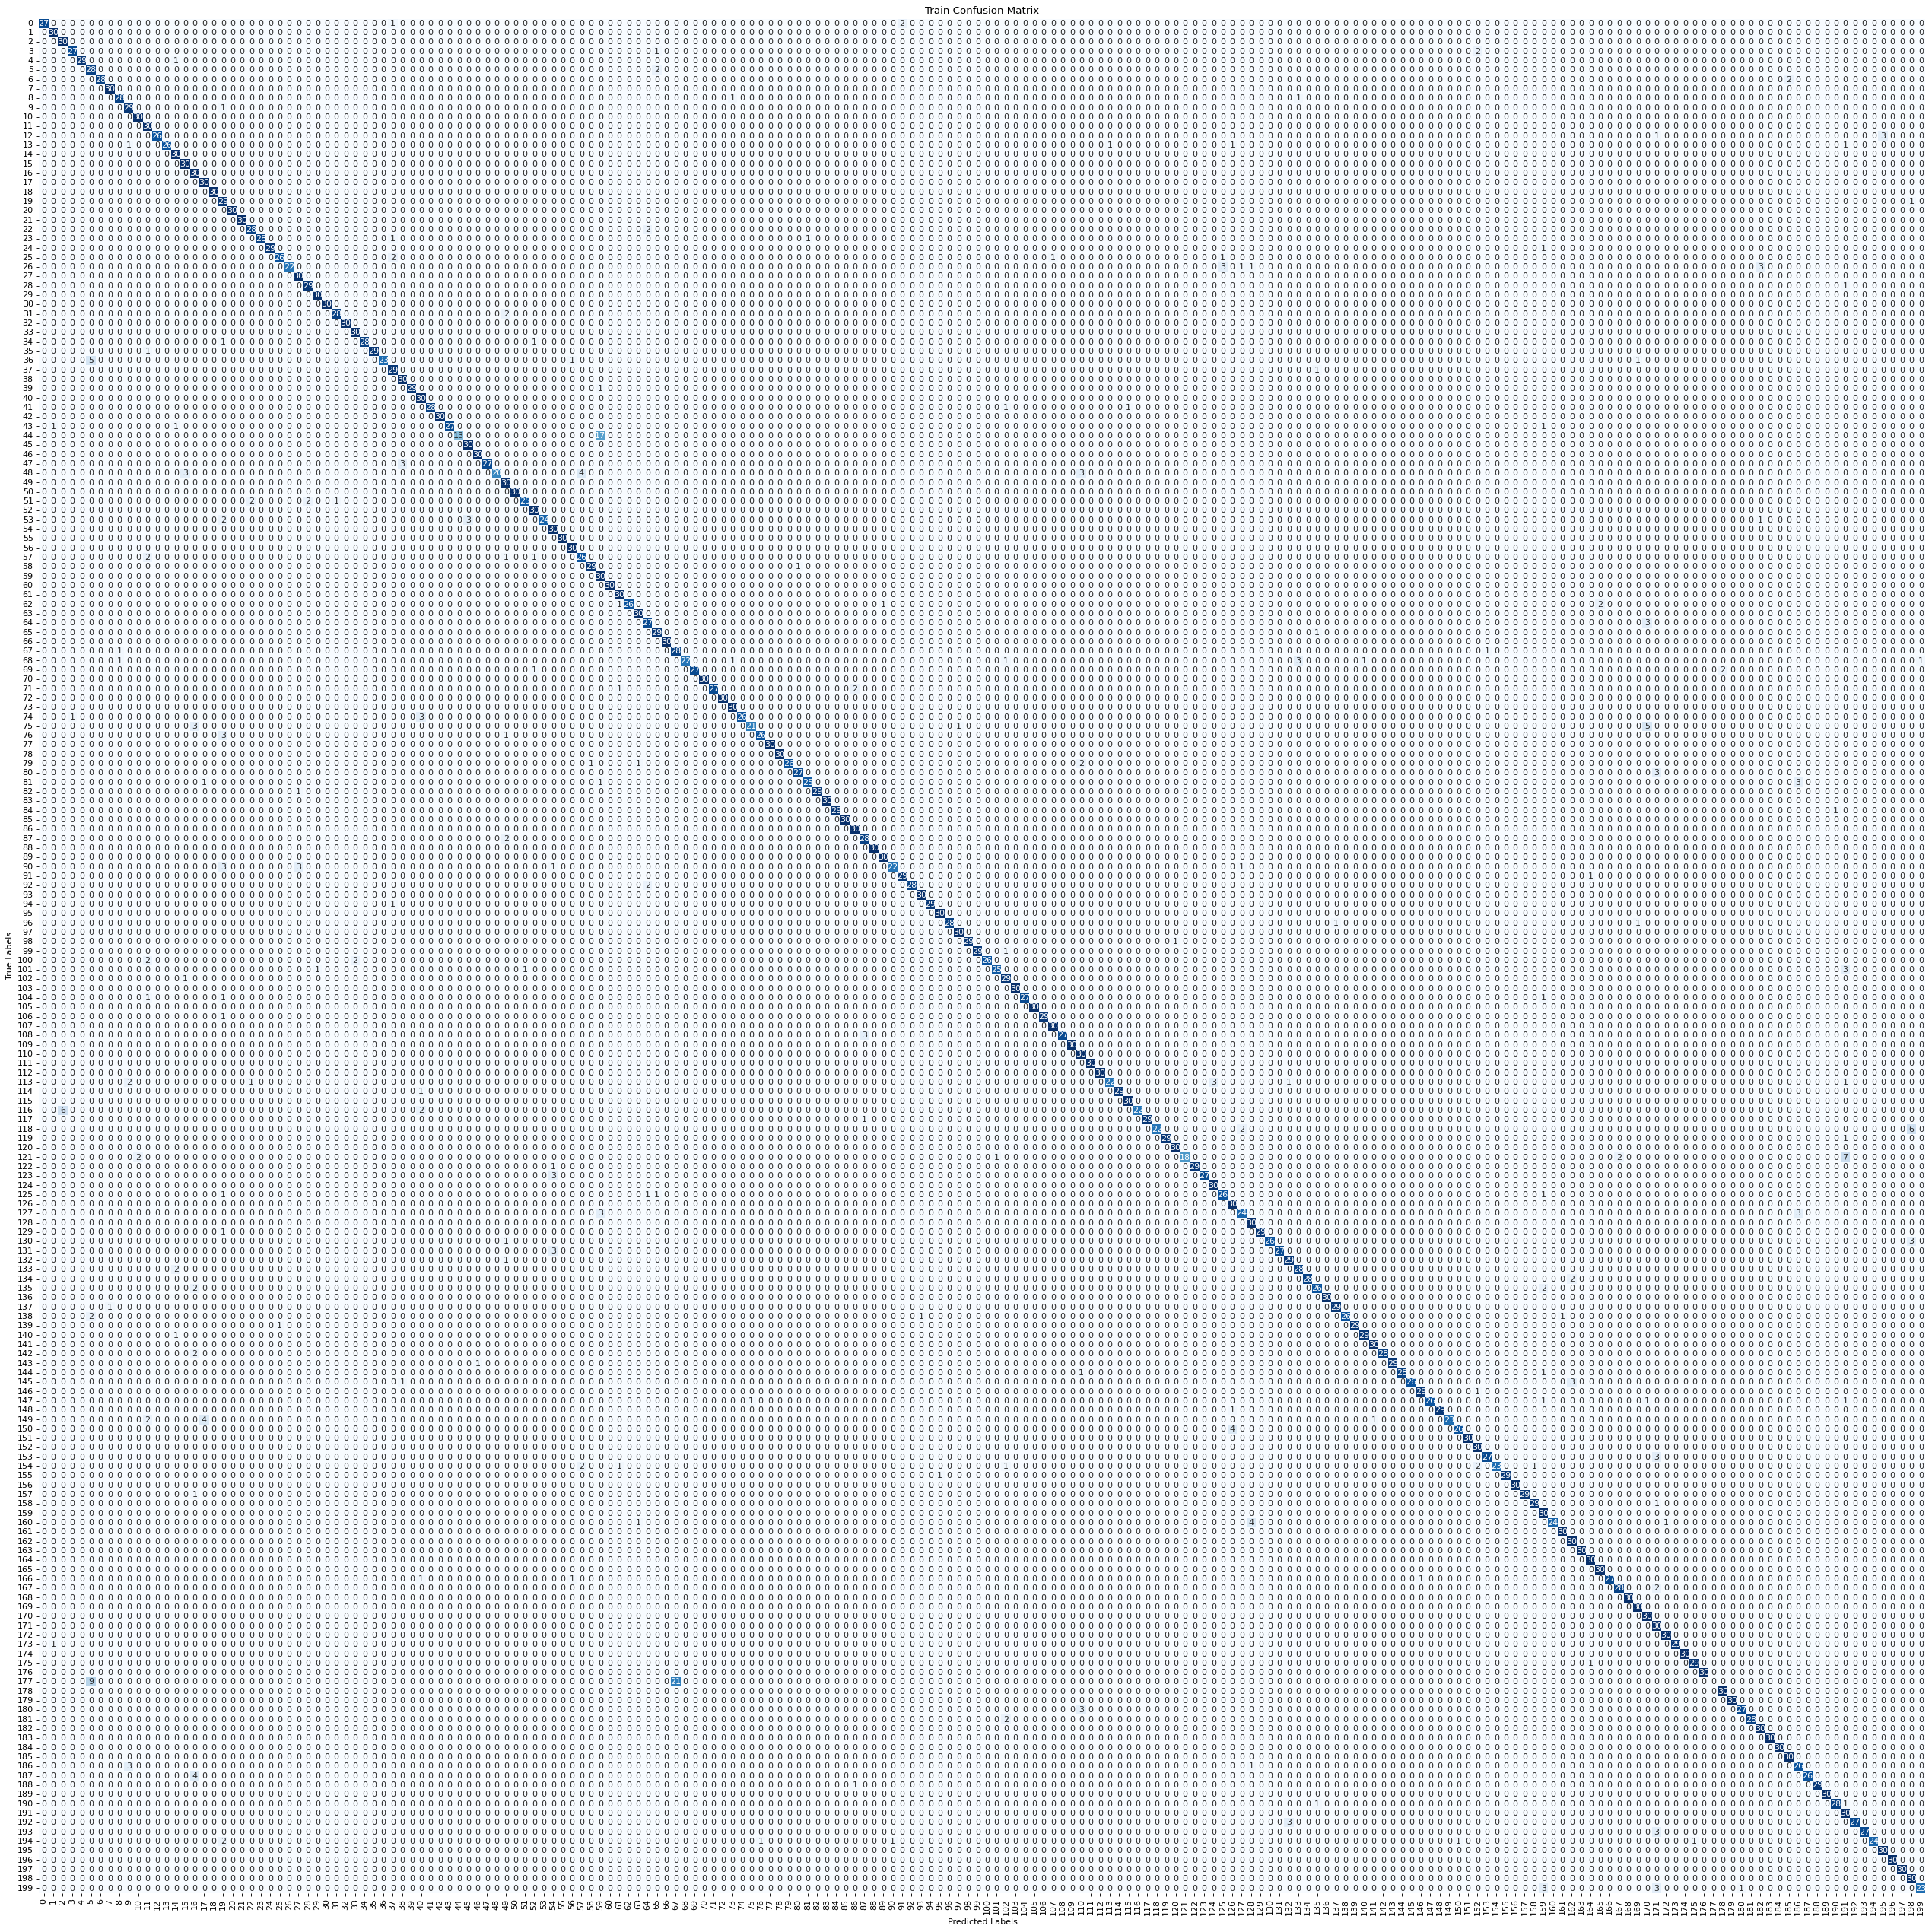

In [22]:
# Compute the confusion matrix
conf_matrix_train = confusion_matrix(y_true_train, y_pred_train)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(40, 40), dpi=80)
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels and titles
plt.title("Train Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()

## Data Test

In [23]:
#extract class list from our annotations
with open('test/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [24]:
coco_gt = COCO('test/_annotations.coco.json')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [25]:
y_true_test = []
y_pred_test = []
pred_scores_test = []
true_labels_test = []
pred_labels_test = []
for i in coco_gt.getImgIds():
  images_info = coco_gt.loadImgs(i)
  try:
    img_path = 'test/'+ images_info[0]['file_name']
    annots_info = coco_gt.loadAnns(i)
    y_true_test.append(class_list[annots_info[0]['category_id']])
    true_labels_test.append(annots_info[0]['category_id'])
    image_filename = os.path.basename(img_path)
    img = cv2.imread(img_path);
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    image = img.astype(np.float32) / 255.;
    image = (image.astype(np.float32) - system_dict["local"]["mean"]) / system_dict["local"]["std"]
    height, width, _ = image.shape
    if height > width:
        scale = system_dict["local"]["common_size"] / height
        resized_height = system_dict["local"]["common_size"]
        resized_width = int(width * scale)
    else:
        scale = system_dict["local"]["common_size"] / width
        resized_height = int(height * scale)
        resized_width = system_dict["local"]["common_size"]

    image = cv2.resize(image, (resized_width, resized_height))

    new_image = np.zeros((system_dict["local"]["common_size"], system_dict["local"]["common_size"], 3))
    new_image[0:resized_height, 0:resized_width] = image

    img = torch.from_numpy(new_image)

    with torch.no_grad():
        # kalau pakai cpu ganti:
        #scores, labels, boxes = system_dict["local"]["model"](img.cpu().permute(2, 0, 1).float().unsqueeze(dim=0))
        # kalau pakai gpu:
        scores, labels, boxes = system_dict["local"]["model"](img.cuda().permute(2, 0, 1).float().unsqueeze(dim=0))
        boxes /= scale;

    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()  # Convert Tensor to list
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()  # Convert Tensor to list
    if isinstance(scores, torch.Tensor):
        scores = scores.tolist()
    try:
      y_pred_test.append(class_list[labels[0]])
      pred_scores_test.append(scores)
      pred_labels_test.append(labels)
    except:
      rndm = np.random.randint(1, 201)
      y_pred_test.append(class_list[rndm])
      pred_scores_test.append(np.random.random(1)[0])
      pred_labels_test.append([rndm])
  except:
    pass

In [26]:
print(pred_scores_test)

[[0.9971899390220642], [0.6582538485527039], [0.8380999565124512], [0.998146653175354], [0.965937614440918], [0.9983357787132263], [0.9933626651763916], [0.9573753476142883], [0.9840111136436462], [0.828684389591217], [0.9729160666465759], [0.8098833560943604], [0.9671204090118408], [0.9032909274101257], [0.9623799324035645], [0.9137846827507019], [0.9869661331176758], [0.9864783883094788], [0.9663759469985962], [0.8705952763557434], [0.9928533434867859], [0.9661621451377869], [0.9770316481590271], [0.9813762903213501], [0.9496859312057495], [0.9820888042449951], [0.9936605095863342], [0.9676626920700073], [0.7430062890052795], [0.9838930368423462], [0.9657798409461975], [0.9791901111602783], [0.7312512993812561], [0.9952113032341003], [0.9495263695716858], [0.9566113352775574], [0.7007032632827759], [0.9045202732086182], [0.9173738956451416], [0.9287139773368835], [0.9992585778236389], [0.9935223460197449], [0.8714835047721863], [0.9886709451675415], [0.9480572938919067], [0.919938445

In [27]:
flattened_pred_scores_test = [max(scores_) if isinstance(scores_, list) else scores_ for scores_ in pred_scores_test]

In [28]:
# One-hot encode the labels
n_classes = 201
true_labels_one_hot_test = np.zeros((len(true_labels_test), n_classes))
for i, label in enumerate(true_labels_test):
    true_labels_one_hot_test[i, label] = 1

pred_labels_one_hot_test = np.zeros((len(pred_labels_test), n_classes))
for i, labels in enumerate(pred_labels_test):
    max_label_idx = labels[np.argmax(pred_scores_test[i])]  # Take the label with the max score
    pred_labels_one_hot_test[i, max_label_idx] = flattened_pred_scores_test[i]

In [29]:
# Calculate Mean Average Precision (mAP)
def calculate_map(y_true, y_pred):
    ap_list = []
    for i in range(y_true.shape[1]):  # Iterate through each class
        if np.sum(y_true[:, i]) == 0:  # Skip if class is not present in true labels
            continue
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        ap_list.append(ap)
    mAP = np.mean(ap_list) if ap_list else 0  # Mean of AP across all classes
    return mAP

# Calculate Mean Average Recall (mAR)
def calculate_mar(y_true, y_pred):
    recall_list = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) == 0:  # Skip if class is not present in true labels
            continue
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        ar = np.mean(recall)  # Average Recall for the current class
        recall_list.append(ar)
    mAR = np.mean(recall_list) if recall_list else 0  # Mean of AR across all classes
    return mAR

# Calculate IoU
def calculate_iou(y_true, y_pred):
    iou_list = []
    for i in range(y_true.shape[1]):
        intersection = np.sum(np.logical_and(y_true[:, i], y_pred[:, i]))  # True Positives
        union = np.sum(np.logical_or(y_true[:, i], y_pred[:, i]))  # True Positives + False Positives + False Negatives
        if union > 0:  # Avoid division by zero
            iou = intersection / union
            iou_list.append(iou)
    mIoU = np.mean(iou_list) if iou_list else 0  # Mean IoU across all classes
    return mIoU

In [30]:
# Calculate mAP and mAR
mAP_test = calculate_map(true_labels_one_hot_test, pred_labels_one_hot_test)
mAR_test = calculate_mar(true_labels_one_hot_test, pred_labels_one_hot_test)
IoU_test = calculate_iou(true_labels_one_hot_test, pred_labels_one_hot_test)

print(f"Test Mean Average Precision (mAP): {mAP_test}")
print(f"Test Mean Average Recall (mAR): {mAR_test}")
print(f"Test Intersection over Union (IoU): {IoU_test}")


Test Mean Average Precision (mAP): 0.9000079379933791
Test Mean Average Recall (mAR): 0.5289641073580702
Test Intersection over Union (IoU): 0.8353994543038661


In [31]:
len(np.unique(y_true_test))

200

In [32]:
# Compute the classification report
class_report_test = classification_report(y_true_test, y_pred_test)

# Print the classification report
print("Test Classification Report:")
print(class_report_test)


Test Classification Report:
              precision    recall  f1-score   support

     1 ban 4       1.00      0.90      0.95        10
     1 jie 2       1.00      1.00      1.00        10
     1 shu 4       0.75      0.90      0.82        10
    1 tong 2       1.00      0.90      0.95        10
     1 wei 4       1.00      0.70      0.82        10
     1 xin 1       0.75      0.90      0.82        10
      1 yi 4       1.00      1.00      1.00        10
     1 yue 4       1.00      1.00      1.00        10
     1 zhi 1       0.90      0.90      0.90        10
     2 bao 4       0.91      1.00      0.95        10
      2 fu 2       1.00      0.90      0.95        10
    2 jian 4       0.62      0.80      0.70        10
     2 jie 2       1.00      0.90      0.95        10
      2 qu 2       1.00      1.00      1.00        10
     2 shu 4       0.91      1.00      0.95        10
      2 ti 4       0.91      1.00      0.95        10
     2 zhi 1       0.50      1.00      0.67        10

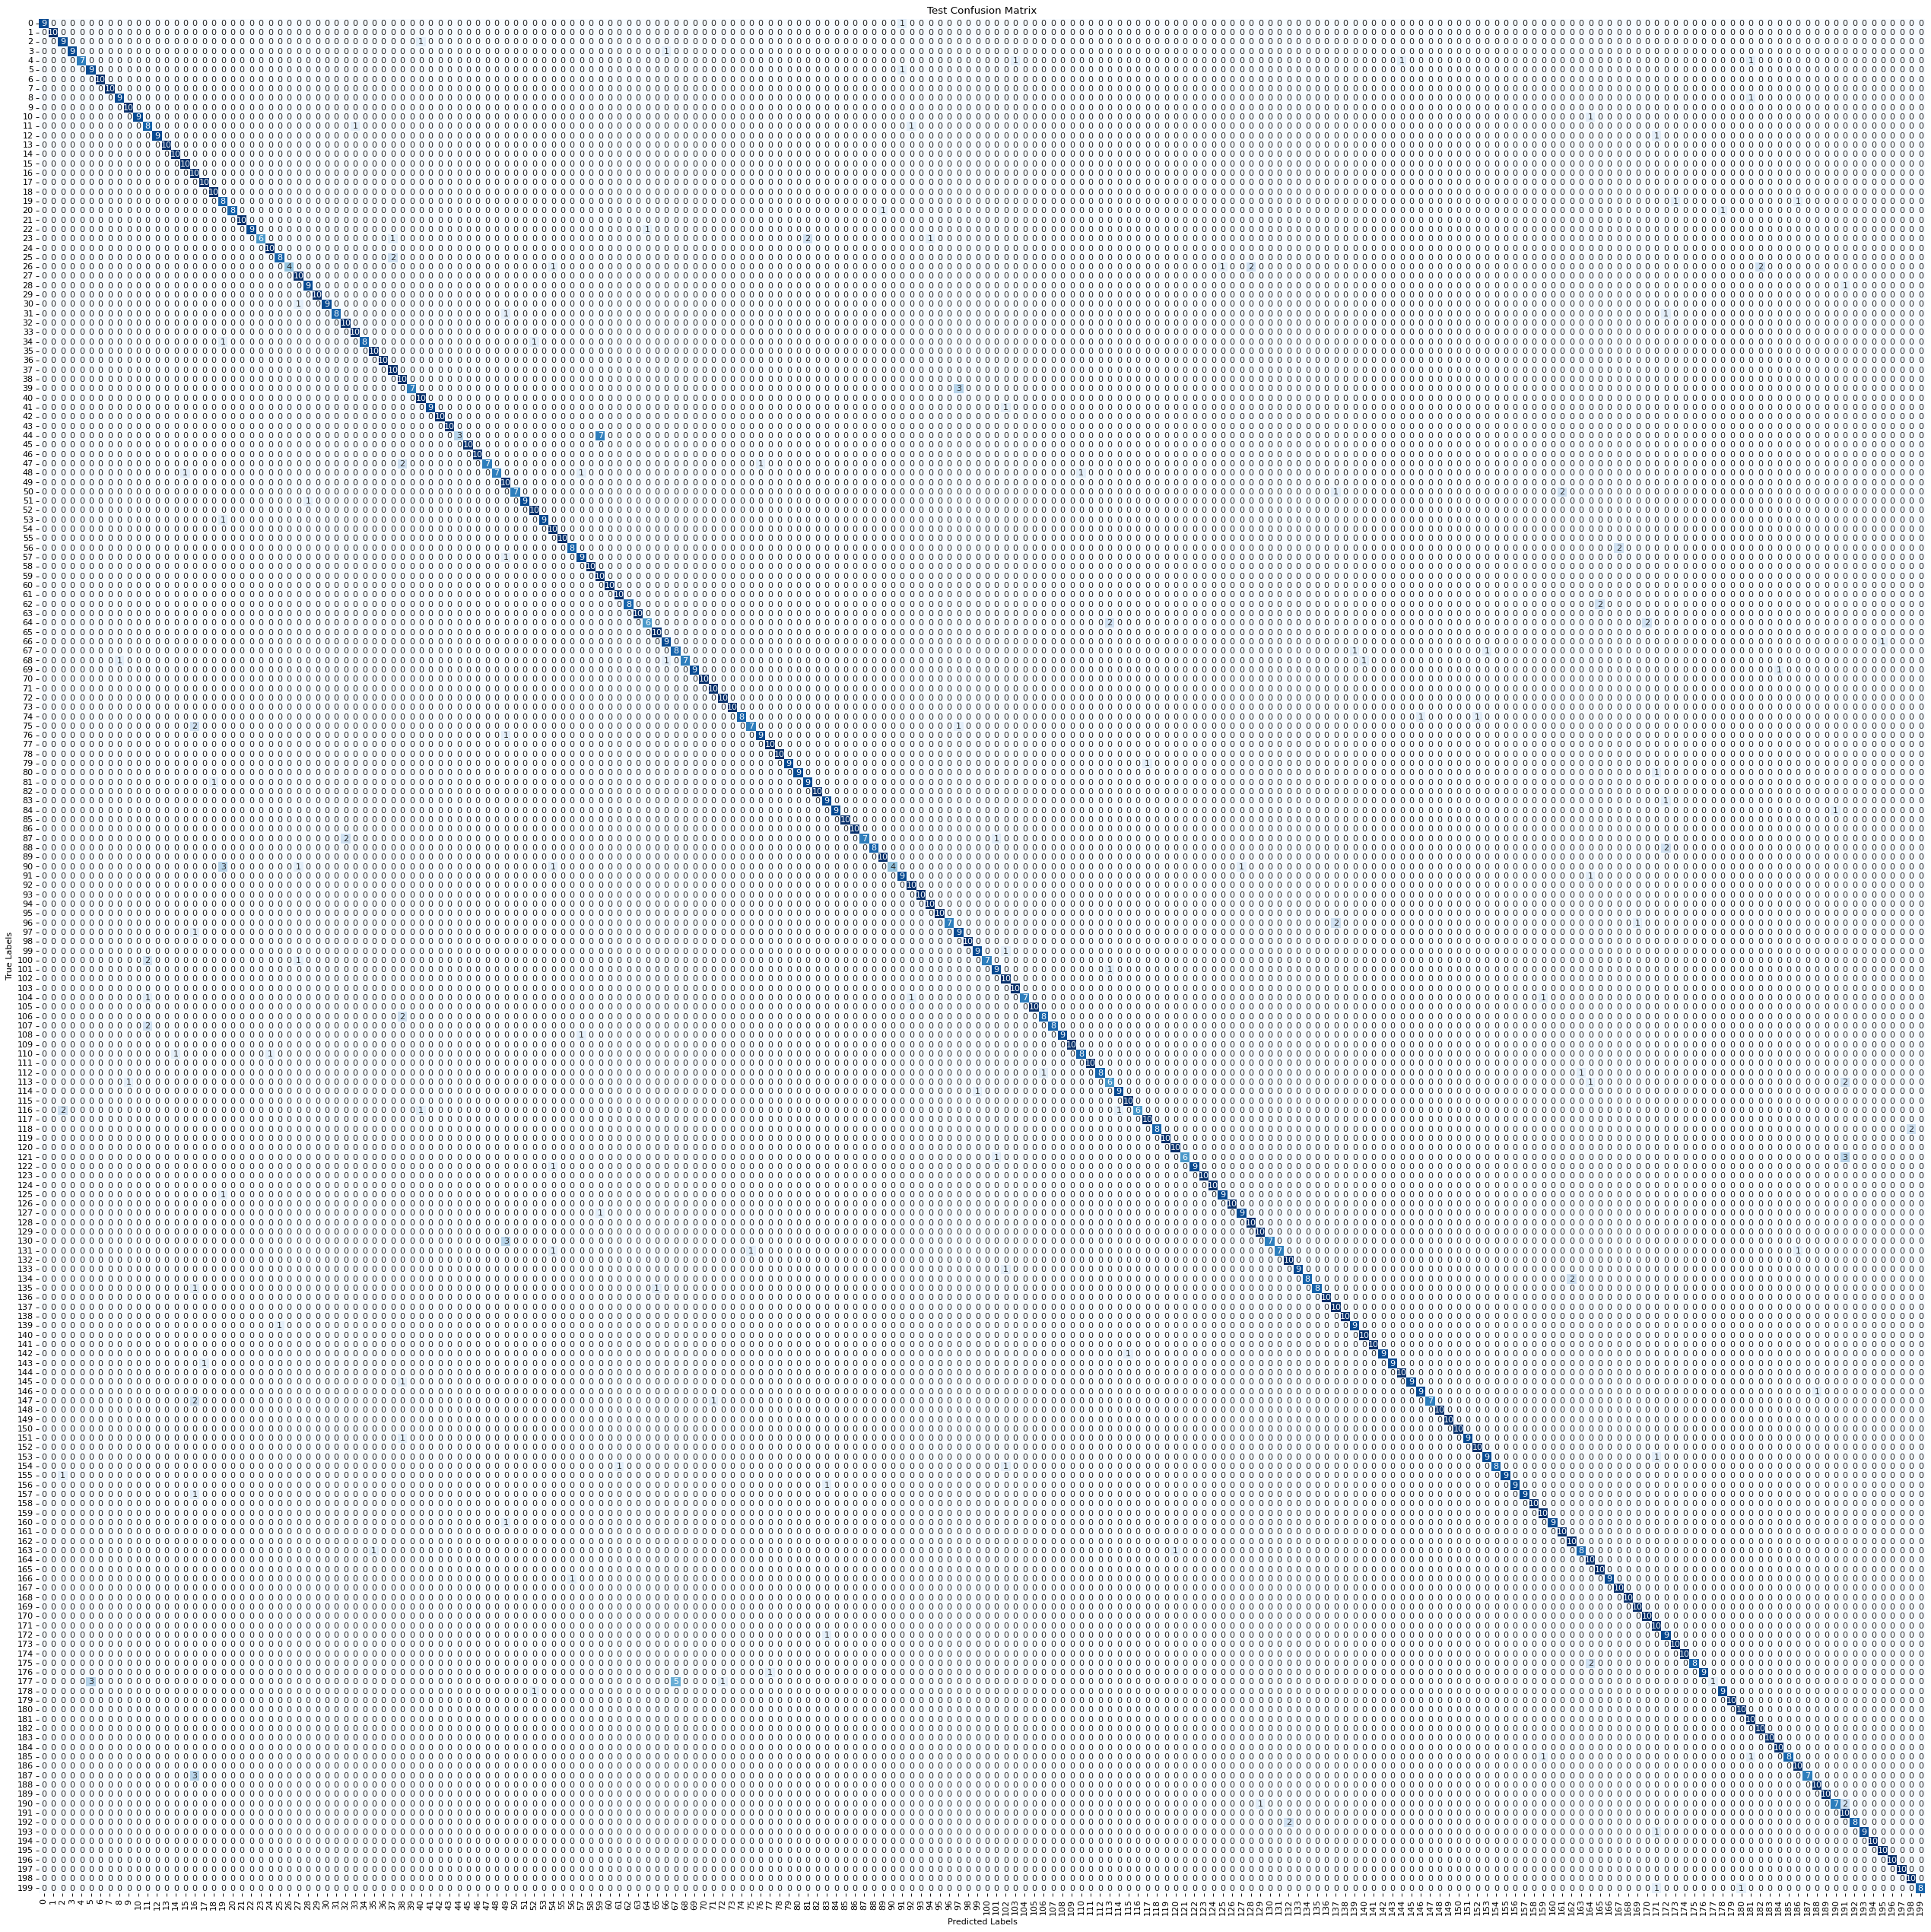

In [33]:
# Compute the confusion matrix
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)

# Plot the cvonfusion matrix using seaborn heatmap
plt.figure(figsize=(40, 40), dpi=80)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels and titles
plt.title("Test Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()

## Data Valid

In [34]:
#extract class list from our annotations
with open('valid/_annotations.coco.json') as json_file:
    data = json.load(json_file)
class_list = []
for category in data['categories']:
  class_list.append(category['name'])

In [35]:
coco_gt = COCO('valid/_annotations.coco.json')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [36]:
y_true_valid = []
y_pred_valid = []
pred_scores_valid = []
true_labels_valid = []
pred_labels_valid = []
for i in coco_gt.getImgIds():
  images_info = coco_gt.loadImgs(i)
  try:
    img_path = 'valid/'+ images_info[0]['file_name']
    annots_info = coco_gt.loadAnns(i)
    y_true_valid.append(class_list[annots_info[0]['category_id']])
    true_labels_valid.append(annots_info[0]['category_id'])
    image_filename = os.path.basename(img_path)
    img = cv2.imread(img_path);
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
    image = img.astype(np.float32) / 255.;
    image = (image.astype(np.float32) - system_dict["local"]["mean"]) / system_dict["local"]["std"]
    height, width, _ = image.shape
    if height > width:
        scale = system_dict["local"]["common_size"] / height
        resized_height = system_dict["local"]["common_size"]
        resized_width = int(width * scale)
    else:
        scale = system_dict["local"]["common_size"] / width
        resized_height = int(height * scale)
        resized_width = system_dict["local"]["common_size"]

    image = cv2.resize(image, (resized_width, resized_height))

    new_image = np.zeros((system_dict["local"]["common_size"], system_dict["local"]["common_size"], 3))
    new_image[0:resized_height, 0:resized_width] = image

    img = torch.from_numpy(new_image)

    with torch.no_grad():
        # kalau pakai cpu ganti:
        #scores, labels, boxes = system_dict["local"]["model"](img.cpu().permute(2, 0, 1).float().unsqueeze(dim=0))
        # kalau pakai gpu:
        scores, labels, boxes = system_dict["local"]["model"](img.cuda().permute(2, 0, 1).float().unsqueeze(dim=0))
        boxes /= scale;

    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()  # Convert Tensor to list
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()  # Convert Tensor to list
    if isinstance(scores, torch.Tensor):
        scores = scores.tolist()
    try:
      y_pred_valid.append(class_list[labels[0]])
      pred_scores_valid.append(scores)
      pred_labels_valid.append(labels)
    except:
      rndm = np.random.randint(1, 201)
      y_pred_valid.append(class_list[rndm])
      pred_scores_valid.append(np.random.random(1)[0])
      pred_labels_valid.append([rndm])
  except:
    pass

In [37]:
print(pred_scores_valid)

[[0.9765154123306274], [0.7770721316337585], [0.9974741339683533], [0.999011754989624], [0.9868196249008179], [0.9679306745529175], [0.9092813730239868], [0.9918166995048523], [0.9802916049957275, 0.06636376678943634], [0.9133284091949463], [0.9814940690994263], [0.8697327375411987], [0.9696565270423889], [0.9851869940757751], [0.9984295964241028], [0.983873188495636], [0.9677225351333618], [0.9344626069068909], [0.9922230839729309], [0.8185998797416687], [0.992628812789917], [0.9834814667701721], [0.8799660205841064], [0.9231833815574646], [0.9937964677810669], [0.998656153678894], [0.9757510423660278], [0.8581878542900085], [0.9619015455245972], [0.8637136220932007], [0.9917427897453308], [0.9927802681922913], [0.9879805445671082], [0.9814638495445251], [0.787196695804596], [0.9902721047401428], [0.6303818225860596], [0.9152194857597351], [0.9921952486038208], [0.9500927329063416], [0.6983520984649658], [0.9550845623016357], [0.9851503968238831], [0.9930843114852905], [0.699195206165

In [38]:
flattened_pred_scores_valid = [max(scores_) if isinstance(scores_, list) else scores_ for scores_ in pred_scores_valid]

In [39]:
# One-hot encode the labels
n_classes = 201
true_labels_one_hot_valid = np.zeros((len(true_labels_valid), n_classes))
for i, label in enumerate(true_labels_valid):
    true_labels_one_hot_valid[i, label] = 1

pred_labels_one_hot_valid = np.zeros((len(pred_labels_valid), n_classes))
for i, labels in enumerate(pred_labels_valid):
    max_label_idx = labels[np.argmax(pred_scores_valid[i])]  # Take the label with the max score
    pred_labels_one_hot_valid[i, max_label_idx] = flattened_pred_scores_valid[i]

In [40]:
# Calculate Mean Average Precision (mAP)
def calculate_map(y_true, y_pred):
    ap_list = []
    for i in range(y_true.shape[1]):  # Iterate through each class
        if np.sum(y_true[:, i]) == 0:  # Skip if class is not present in true labels
            continue
        ap = average_precision_score(y_true[:, i], y_pred[:, i])
        ap_list.append(ap)
    mAP = np.mean(ap_list) if ap_list else 0  # Mean of AP across all classes
    return mAP

# Calculate Mean Average Recall (mAR)
def calculate_mar(y_true, y_pred):
    recall_list = []
    for i in range(y_true.shape[1]):
        if np.sum(y_true[:, i]) == 0:  # Skip if class is not present in true labels
            continue
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        ar = np.mean(recall)  # Average Recall for the current class
        recall_list.append(ar)
    mAR = np.mean(recall_list) if recall_list else 0  # Mean of AR across all classes
    return mAR

# Calculate IoU
def calculate_iou(y_true, y_pred):
    iou_list = []
    for i in range(y_true.shape[1]):
        intersection = np.sum(np.logical_and(y_true[:, i], y_pred[:, i]))  # True Positives
        union = np.sum(np.logical_or(y_true[:, i], y_pred[:, i]))  # True Positives + False Positives + False Negatives
        if union > 0:  # Avoid division by zero
            iou = intersection / union
            iou_list.append(iou)
    mIoU = np.mean(iou_list) if iou_list else 0  # Mean IoU across all classes
    return mIoU

In [41]:
# Calculate mAP and mAR
mAP_valid = calculate_map(true_labels_one_hot_valid, pred_labels_one_hot_valid)
mAR_valid = calculate_mar(true_labels_one_hot_valid, pred_labels_one_hot_valid)
IoU_valid = calculate_iou(true_labels_one_hot_valid, pred_labels_one_hot_valid)

print(f"Valid Mean Average Precision (mAP): {mAP_valid}")
print(f"Valid Mean Average Recall (mAR): {mAR_valid}")
print(f"Valid Intersection over Union (IoU): {IoU_valid}")

Valid Mean Average Precision (mAP): 0.8983636796863267
Valid Mean Average Recall (mAR): 0.5284162422136687
Valid Intersection over Union (IoU): 0.8345430936023042


In [42]:
len(np.unique(y_true_valid))

200

In [43]:
# Compute the classification report
class_report_valid = classification_report(y_true_valid, y_pred_valid)

# Print the classification report
print("Valid Classification Report:")
print(class_report_valid)

Valid Classification Report:
              precision    recall  f1-score   support

     1 ban 4       1.00      0.90      0.95        10
     1 jie 2       0.91      1.00      0.95        10
     1 shu 4       1.00      1.00      1.00        10
    1 tong 2       0.82      0.90      0.86        10
     1 wei 4       1.00      0.80      0.89        10
     1 xin 1       0.69      0.90      0.78        10
      1 yi 4       1.00      0.80      0.89        10
     1 yue 4       0.90      0.90      0.90        10
     1 zhi 1       1.00      0.90      0.95        10
     2 bao 4       0.77      1.00      0.87        10
      2 fu 2       1.00      0.90      0.95        10
    2 jian 4       0.62      1.00      0.77        10
     2 jie 2       0.90      0.90      0.90        10
      2 qu 2       1.00      0.70      0.82        10
     2 shu 4       0.77      1.00      0.87        10
      2 ti 4       0.91      1.00      0.95        10
     2 zhi 1       0.56      1.00      0.71        1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


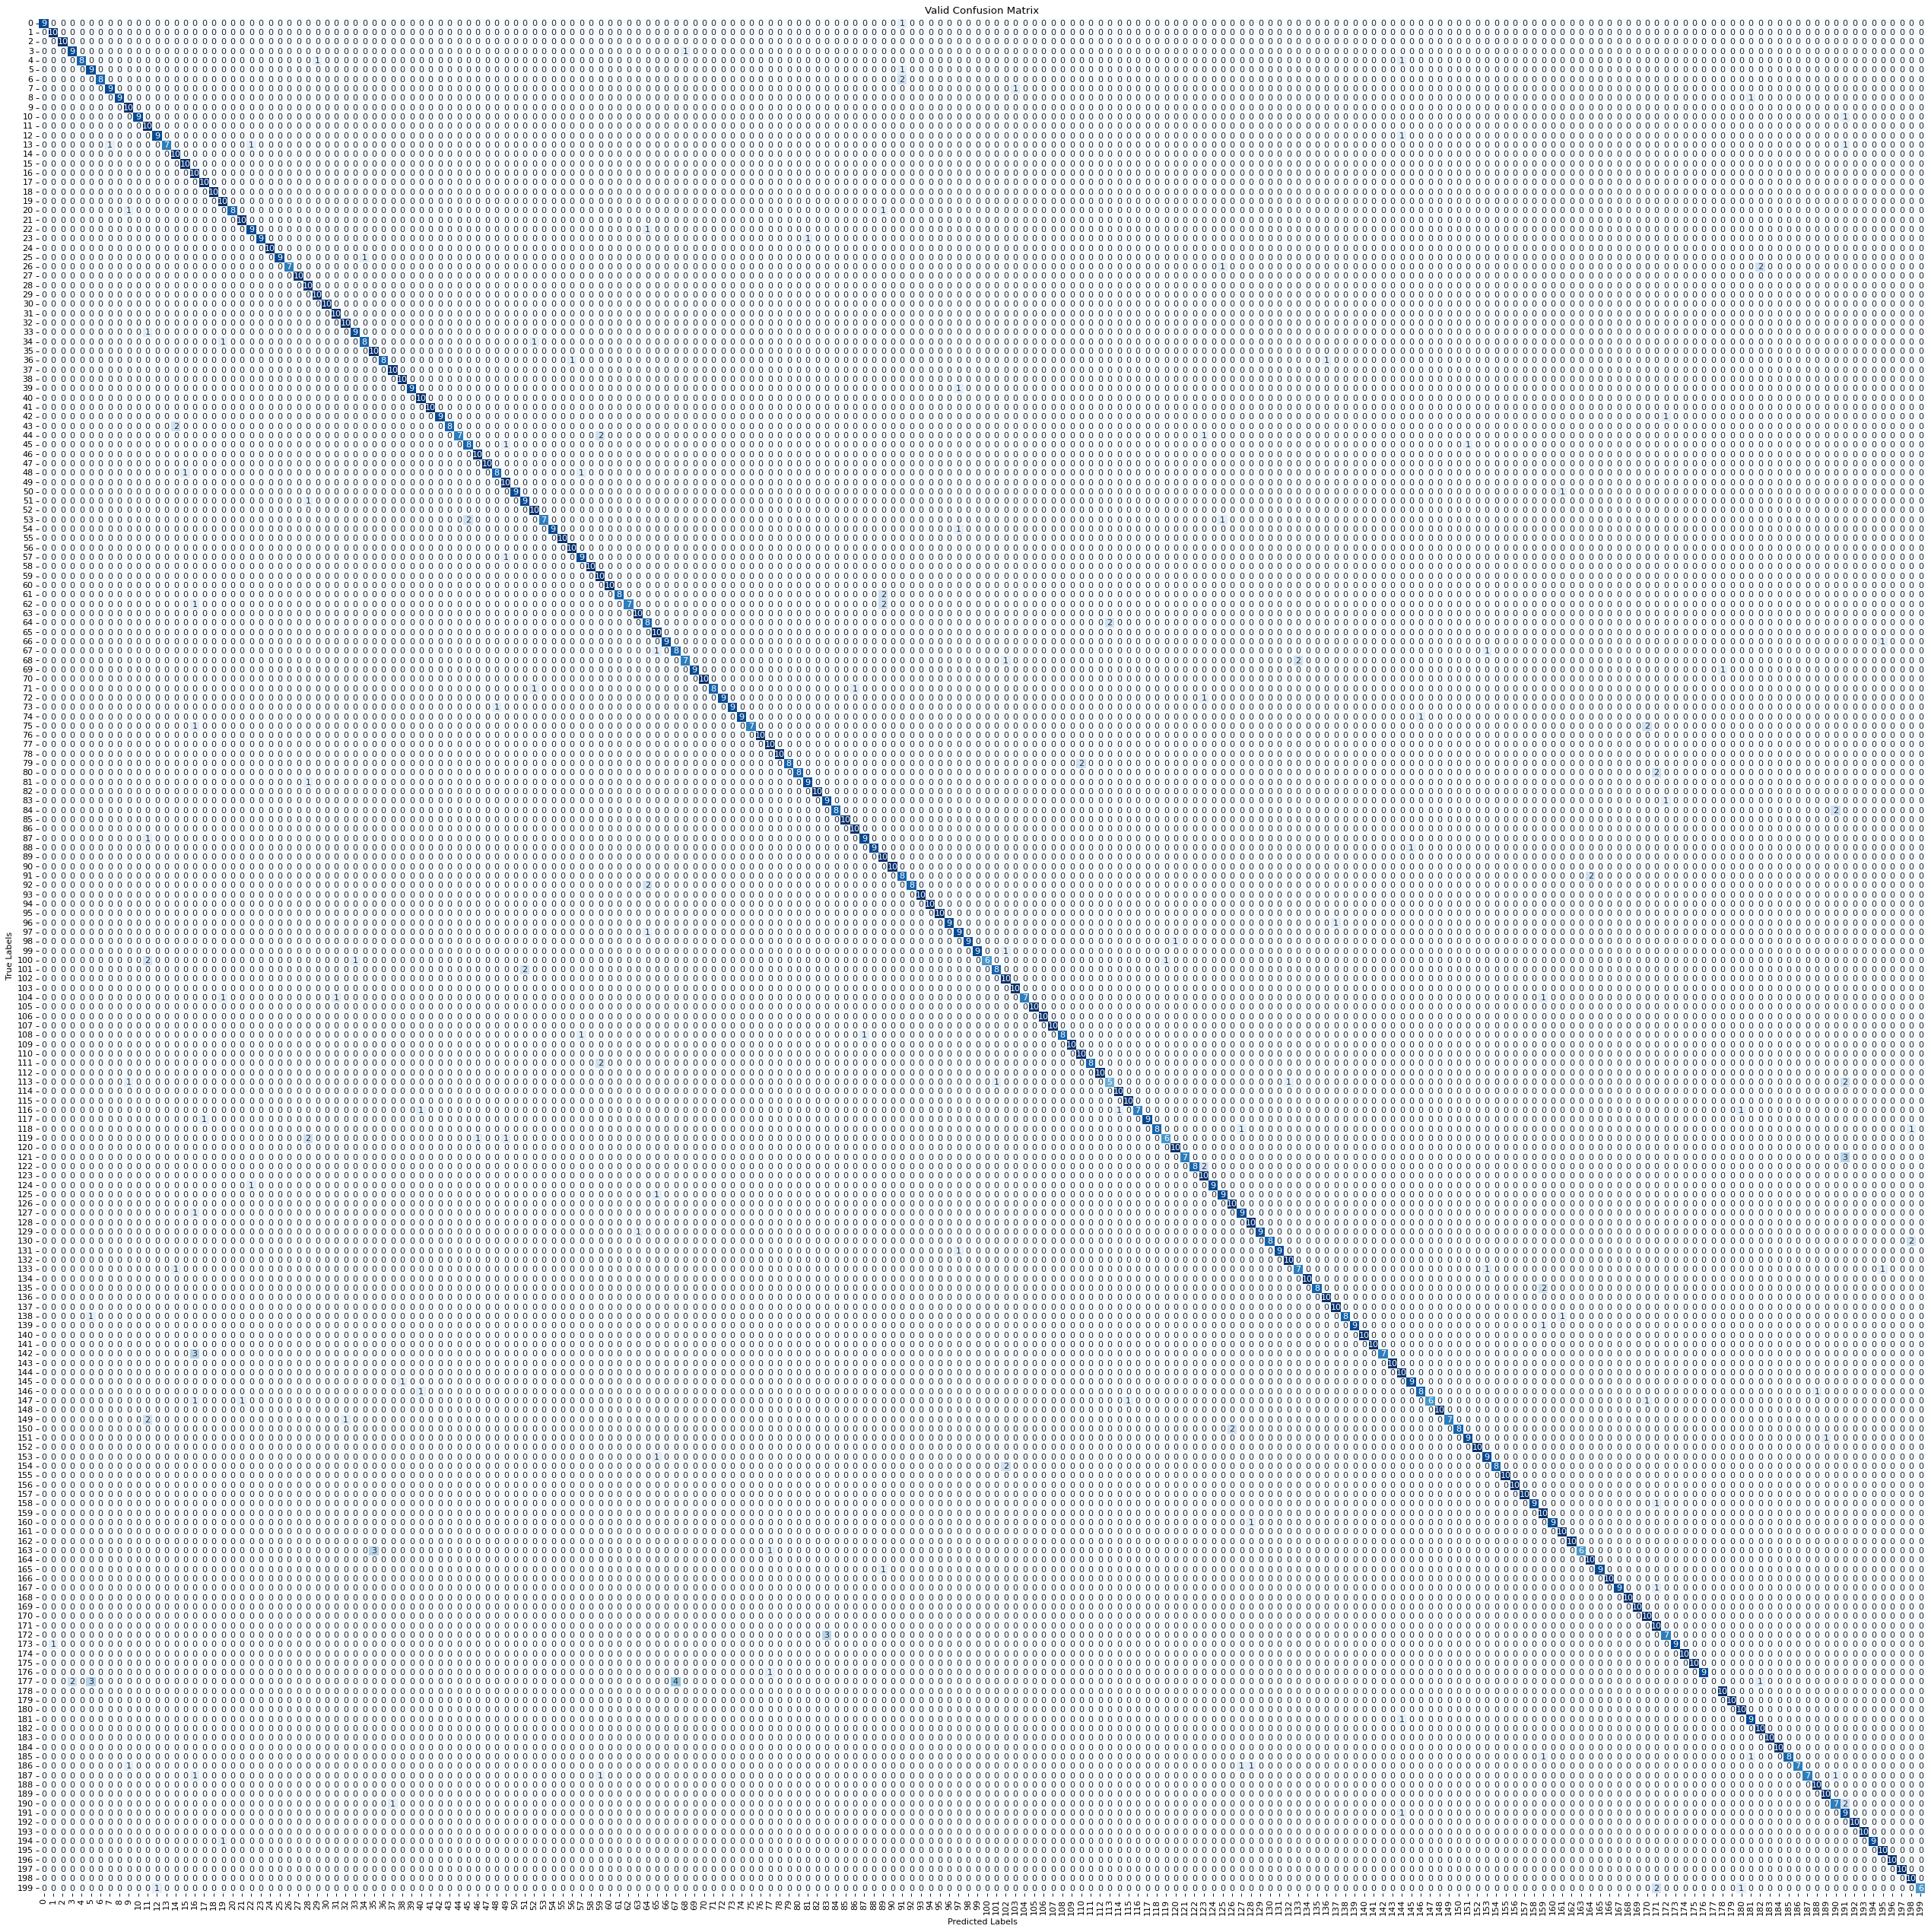

In [44]:
# Compute the confusion matrix
conf_matrix_valid = confusion_matrix(y_true_valid, y_pred_valid)

# Plot the cvonfusion matrix using seaborn heatmap
plt.figure(figsize=(40, 40), dpi=80)
sns.heatmap(conf_matrix_valid, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels and titles
plt.title("Valid Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()

## All Data

In [45]:
def combine(train, test, valid):
    return train+test+valid

In [46]:
y_true = combine(y_true_train, y_true_test, y_true_valid)
y_pred = combine(y_pred_train, y_pred_test, y_pred_valid)
pred_scores = combine(pred_scores_train, pred_scores_test, pred_scores_valid)
true_labels = combine(true_labels_train, true_labels_test, true_labels_valid)
pred_labels = combine(pred_labels_train, pred_labels_test, pred_labels_valid)

In [47]:
flattened_pred_scores = [max(scores_) if isinstance(scores_, list) else scores_ for scores_ in pred_scores]

In [48]:
# One-hot encode the labels
n_classes = 201
true_labels_one_hot = np.zeros((len(true_labels), n_classes))
for i, label in enumerate(true_labels):
    true_labels_one_hot[i, label] = 1

pred_labels_one_hot = np.zeros((len(pred_labels), n_classes))
for i, labels in enumerate(pred_labels):
    max_label_idx = labels[np.argmax(pred_scores[i])]  # Take the label with the max score
    pred_labels_one_hot[i, max_label_idx] = flattened_pred_scores[i]

In [49]:
# Calculate mAP and mAR
mAP = calculate_map(true_labels_one_hot, pred_labels_one_hot)
mAR = calculate_mar(true_labels_one_hot, pred_labels_one_hot)
IoU = calculate_iou(true_labels_one_hot, pred_labels_one_hot)

print(f"Overall Mean Average Precision (mAP): {mAP}")
print(f"Overall Mean Average Recall (mAR): {mAR}")
print(f"Overall Intersection over Union (IoU): {IoU}")


Overall Mean Average Precision (mAP): 0.9182881606853122
Overall Mean Average Recall (mAR): 0.5000791401250214
Overall Intersection over Union (IoU): 0.8628755874220805


In [50]:
# Compute the classification report
class_report = classification_report(y_true, y_pred)

# Print the classification report
print("Overall Classification Report:")
print(class_report)

Overall Classification Report:
              precision    recall  f1-score   support

     1 ban 4       1.00      0.90      0.95        50
     1 jie 2       0.94      1.00      0.97        50
     1 shu 4       0.84      0.98      0.91        50
    1 tong 2       0.94      0.90      0.92        50
     1 wei 4       1.00      0.88      0.94        50
     1 xin 1       0.67      0.92      0.77        50
      1 yi 4       1.00      0.92      0.96        50
     1 yue 4       0.96      0.98      0.97        50
     1 zhi 1       0.94      0.92      0.93        50
     2 bao 4       0.83      0.98      0.90        50
      2 fu 2       0.96      0.96      0.96        50
    2 jian 4       0.72      0.96      0.82        50
     2 jie 2       0.98      0.88      0.93        50
      2 qu 2       1.00      0.86      0.92        50
     2 shu 4       0.85      1.00      0.92        50
      2 ti 4       0.89      1.00      0.94        50
     2 zhi 1       0.62      1.00      0.77       

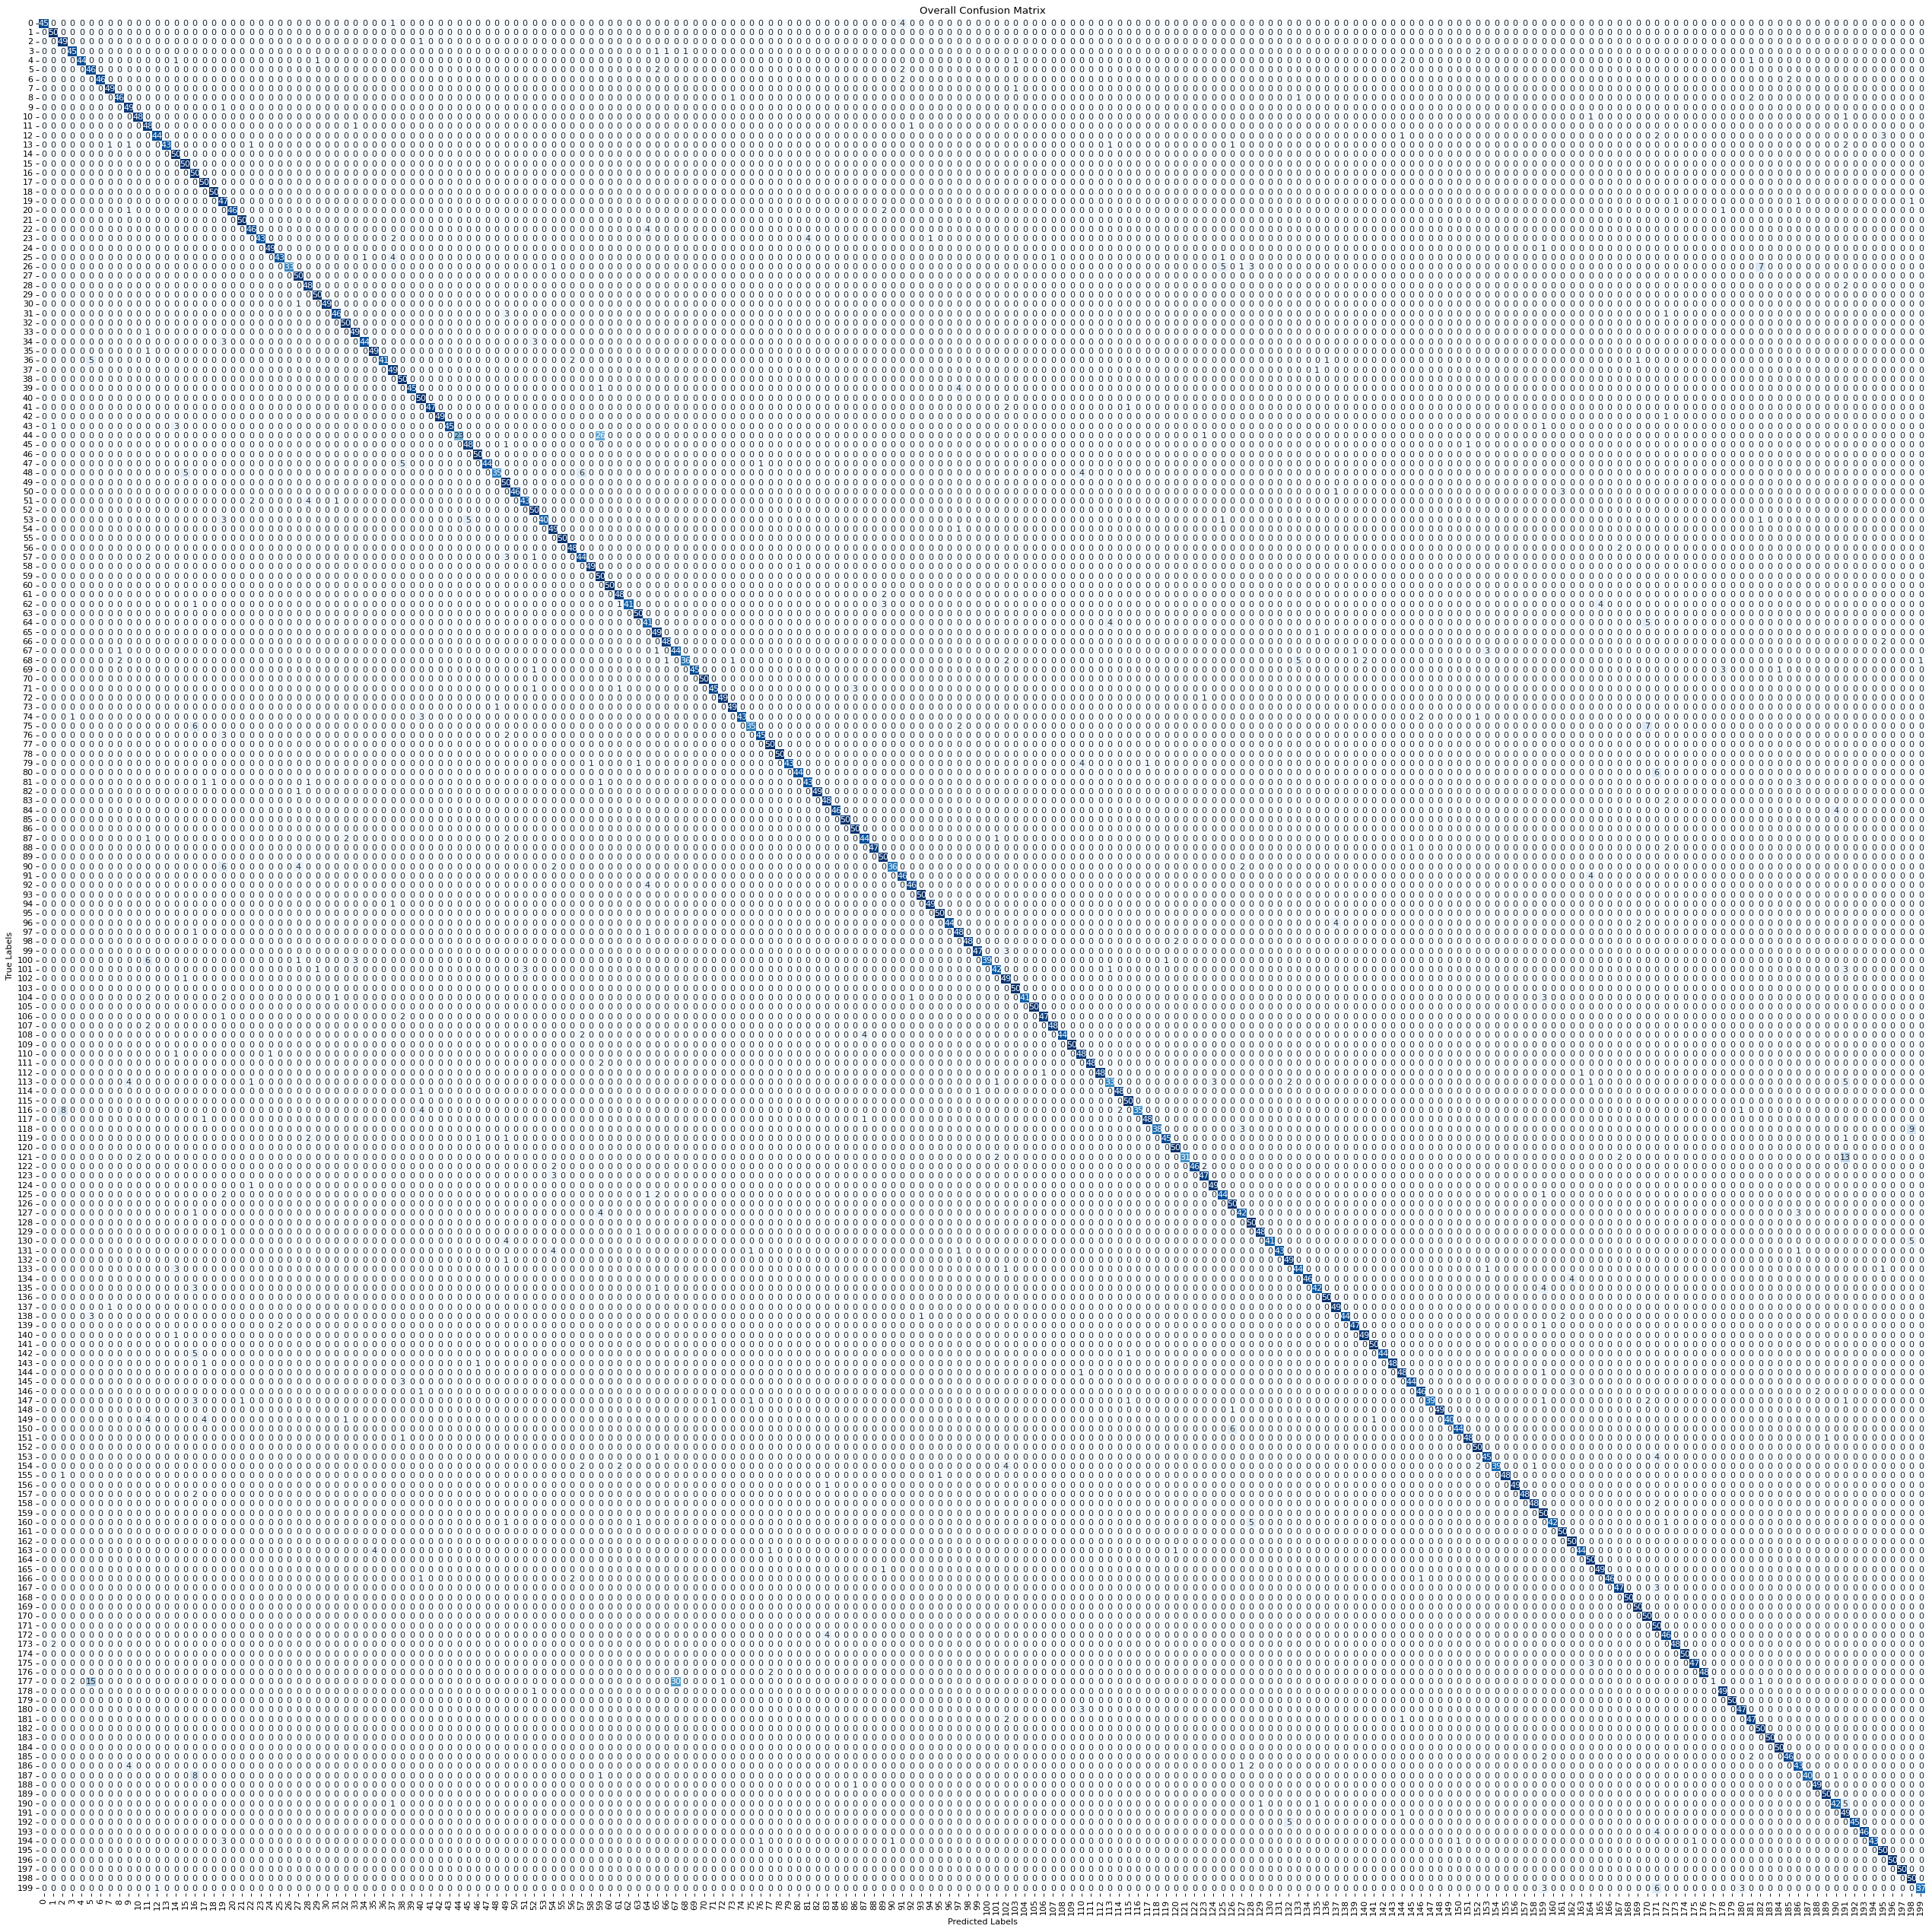

In [51]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the cvonfusion matrix using seaborn heatmap
plt.figure(figsize=(40, 40), dpi=80)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)

# Add labels and titles
plt.title("Overall Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show the plot
plt.show()

# Inference Single Image

In [52]:
class_list = ["mandarin", "1 ban 4", "1 jie 2", "1 shu 4", "1 tong 2", "1 wei 4",
                        "1 xin 1",    "1 yi 4",    "1 yue 4",    "1 zhi 1",    "2 bao 4",
                        "2 fu 2",    "2 jian 4",    "2 jie 2",    "2 qu 2",    "2 shu 4",
                        "2 ti 4",    "2 zhi 1",    "3 bao 4",    "3 fu 2",    "3 heng 2",
                        "3 jian 4",    "3 meng 2",    "3 mo 2",    "3 ti 4",    "3 xin 1",
                        "3 yi 4",    "4 ban 4",    "4 heng 2",    "4 meng 2",    "4 mo 2",
                        "4 qu 2",    "4 tong 2",    "4 wei 4",    "4 yue 4",    "an 4",
                        "ao 2",    "ba 1",    "ban 3",    "bao 2",    "bei 1",
                        "ben 3",    "bi 4",    "bo 4",    "bu 4",    "cai 2",
                        "cang 2",    "cao 1",    "cao 2",    "ceng 2",    "chan 4",
                        "chang 3",    "chao 2",    "cheng 2",    "chu 2",    "chun 1",
                        "chun 3",    "cong 2",    "cu 4",    "cui 4",    "cun 1",
                        "dai 3",    "dai 4",    "dan 4",    "dian 1",    "ding 1",
                        "du 4",    "duo 3",    "er 4",    "fa 2",    "fan 2",
                        "fu 4",    "ge 1",    "ge 4",    "geng 4",    "gong 1",
                        "gou 4",    "guan 4",    "guo 3",    "hang 2",    "hao 2",
                        "he 2",    "he 4",    "hui 1",    "hui 4",    "ji 1",
                        "ji 2",    "jia 4",    "jiang 1",    "jiao 1",    "jiao 4",
                        "jie 3",    "jin 3",    "jin 4",    "jiu 3",    "ju 1",
                        "kang 4",    "kou 3",    "ku 1",    "kui 4",    "lai 2",
                        "lan 3",    "lang 3",    "li 3",    "li 4",    "lian 4",
                        "lin 2",    "lin 3",    "luo 3",    "man 4",    "mao 1",
                        "mei 3",    "men",    "mi 2",    "ming 2",    "mo 4",
                        "mu 3",    "mu 4",    "nang 3",    "nuo 4",    "pan 2",
                        "pei 2",    "peng 2",    "pu 2",    "pu 3",    "qi 1",
                        "qian 4",    "qiang 1",    "qiang 2",    "qiao 1",    "qiao 2",
                        "qiao 4",    "qing 2",    "qu 1",    "qu 4",    "rang 2",
                        "rao 3",    "ren 2",    "ri 4",    "ru 4",    "san 1",
                        "sha 1",    "sha 4",    "shan 1",    "she 4",    "shu 1",
                        "shu 3",    "shui 3",    "si 3",    "song 1",    "tan 3",
                        "tang 2",    "teng 2",    "tiao 2",    "tu 3",    "wai 1",
                        "wang 2",    "wang 4",    "wei 1",    "wen 1",    "wu 3",
                        "xi 1",    "xi 2",    "xian 3",    "xiang 1",    "xiang 4",
                        "xiao 1",    "xiao 3",    "xie 1",    "xie 4",    "xiong 1",
                        "xiu 3",    "xu 1",    "xun 1",    "ya 1",    "yang 2",
                        "yao 4",    "ye 4",    "yi 1",    "ying 1",    "you 3",
                        "you 4",    "yu 3",    "yu 4",    "yuan 2",    "zan 4",
                        "zha 2",    "zhang 1",    "zhang 4",    "zhao 4",    "zhe 4",
                        "zhen 3",    "zhen 4",    "zheng 4",    "zhi 3",    "zhi 4",
                        "zhu 1",    "zong 1",    "zui 4",    "zun 1",    "zuo 3",  ]

In [53]:
def predict_single_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = img.astype(np.float32) / 255
    image = (image.astype(np.float32) - system_dict["local"]["mean"]) / system_dict["local"]["std"]
    height, width, _ = image.shape
    target_size = 512
    if height != width:
        start_row = int((height - 512) / 2)
        start_col = int((width - 512) / 2)
        image = image[start_row:start_row+512, start_col:start_col+512]

    if height > width:
        scale = system_dict["local"]["common_size"] / height
        resized_height = system_dict["local"]["common_size"]
        resized_width = int(width * scale)
    else:
        scale = system_dict["local"]["common_size"] / width
        resized_height = int(height * scale)
        resized_width = system_dict["local"]["common_size"]

    image = cv2.resize(image, (resized_width, resized_height))

    new_image = np.zeros((system_dict["local"]["common_size"], system_dict["local"]["common_size"], 3))
    new_image[0:resized_height, 0:resized_width] = image
    img = torch.from_numpy(new_image)

    with torch.no_grad():
        # if using CPU, replace with the following:
        #scores, labels, boxes = system_dict["local"]["model"](img.cpu().permute(2, 0, 1).float().unsqueeze(dim=0))
        scores, labels, boxes = system_dict["local"]["model"](img.cuda().permute(2, 0, 1).float().unsqueeze(dim=0))
        boxes /= scale

    # Convert boxes, labels, and scores to lists if they are Tensors
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()
    if isinstance(labels, torch.Tensor):
        labels = labels.tolist()
    if isinstance(scores, torch.Tensor):
        scores = scores.tolist()

    image = cv2.imread(img_path)
    # Draw the detected objects
    for i in range(len(scores)):
        x_min, y_min, x_max, y_max = boxes[i]
        class_label = class_list[labels[i]]
        score = scores[i]

        # Draw bounding box and label
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
        label_text = f'{class_label}: {score:.2f}'
        cv2.putText(image, label_text, (int(x_min), int(y_min) - 10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 2)

    # Display the image with bounding boxes
    if height != width:
      image = cv2.resize(image, (512, 512))
    plt.figure(figsize=(20, 20), dpi=50)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return new_image

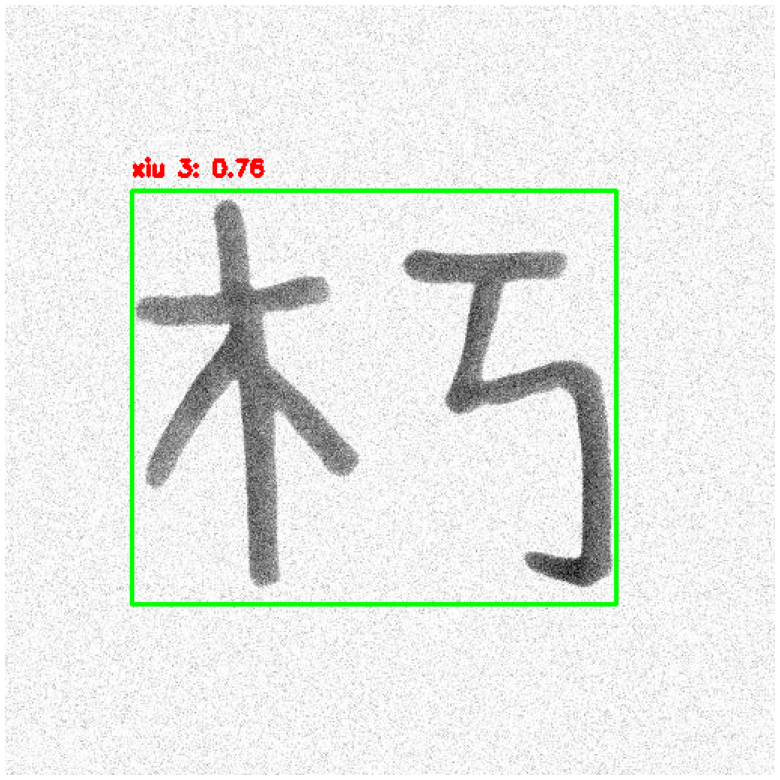

CPU times: user 462 ms, sys: 211 ms, total: 673 ms
Wall time: 428 ms


In [54]:
%%time
## contoh di test folder random selection
test_images = [f for f in os.listdir('test') if f.endswith('.jpg')]
import random
img_path = "test/" + random.choice(test_images);
pred = predict_single_image(img_path)

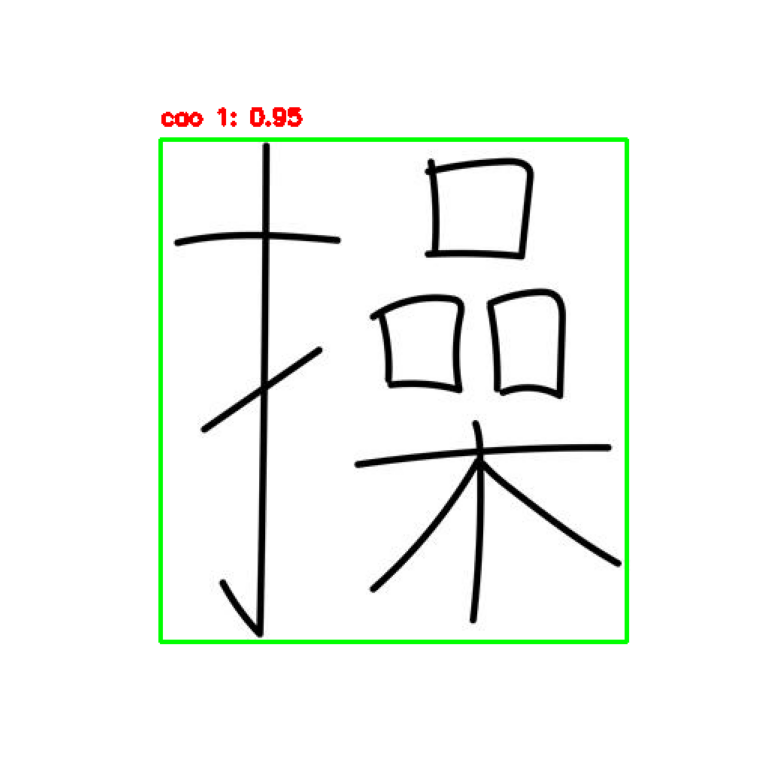

In [55]:
# inference pada path yang sudah ditentukan
pred = predict_single_image('/content/test/1-1-_png.rf.019a53c7e3b3d24a02260c831929bdae.jpg')

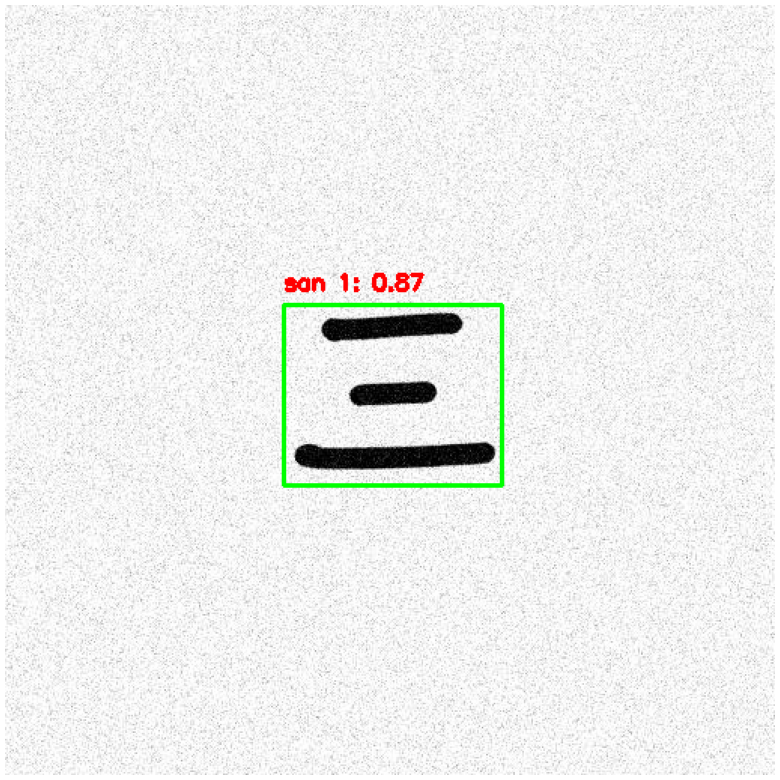

CPU times: user 465 ms, sys: 204 ms, total: 669 ms
Wall time: 419 ms


In [56]:
%%time
pred = predict_single_image('/content/test/1-16-_noisy_1_png.rf.b63c0f31b953c4a49de3423651c16dbc.jpg')

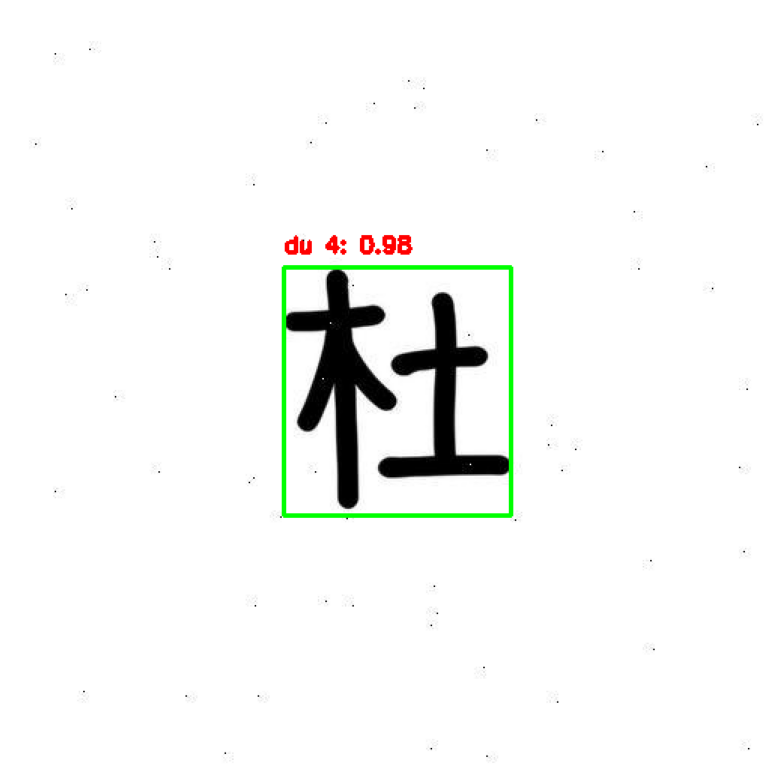

In [ ]:
pred = predict_single_image('/content/test/1-29-_png_jpg.rf.cad70773720aad5247b187cdb813d36f.jpg')

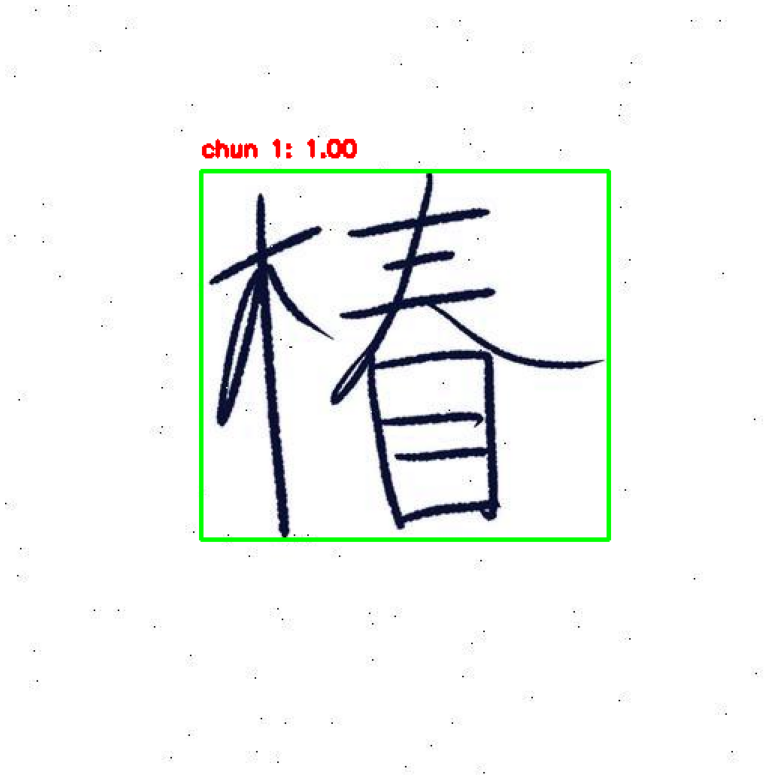

In [ ]:
pred = predict_single_image('/content/test/11_png_jpg.rf.36a0bd71b39709526c7ddb534ba50abe.jpg')

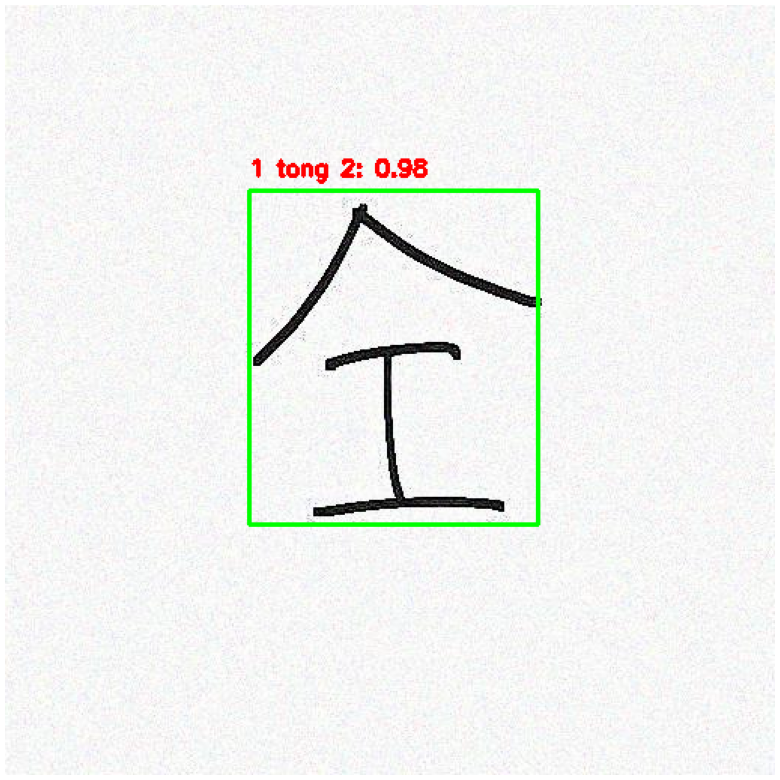

In [ ]:
pred = predict_single_image('/content/drive/MyDrive/Data Noise/gaussianstd15_34.jpg')

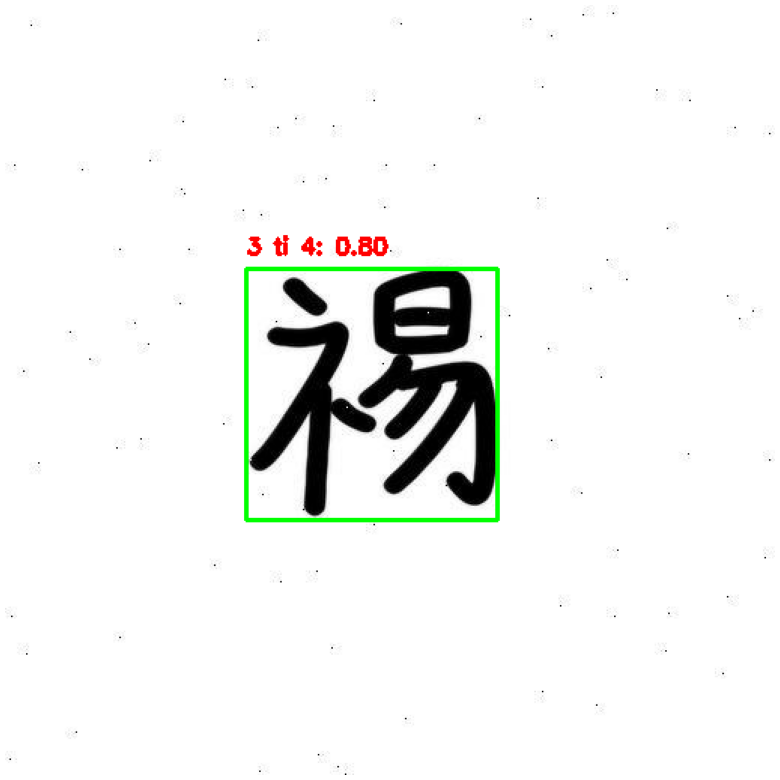

In [ ]:
pred = predict_single_image('/content/test/2-44-_png_jpg.rf.68b3bd7282db42b82c4608c1b7d77c58.jpg')